# <b><u>Abstractive Summarization POC</u></b>

### <b>Importing the libraries & reading Data required for Abstractive POC</b>

In [ ]:
# Importing genism package and summarizer
import gensim
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
!pip install wikipedia

import wikipedia
import textwrap
# Wrap this text.
wrapper = textwrap.TextWrapper(width=150)  

#importing sumy
!pip install sumy
import sumy
import nltk

nltk.download('punkt')
!pip install transformers
!pip install rouge
!pip install clean-text
!pip install PyPDF2
from rouge import Rouge

### <b>Reading PDF Data from Google Drive</b>

In [ ]:
# Using google Colab since PCA and Random forest is computationally expensive on local machine. 

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing all the required modules
#!pip install PyPDF2
import PyPDF2

# creating an object 
file = open('/content/drive/MyDrive/Royal_Haskoning_Main.pdf', 'rb')

# creating a pdf reader object
pdfData = PyPDF2.PdfFileReader(file)

# print the number of pages in pdf file
pages=int(pdfData.numPages)
txt=[]
for i in range(pages):
    
    #extract the page
    page = pdfData.getPage(i)
    page=page.extractText().replace('"','')
    txt.append(page)

listToStr = ' '.join([str(elem) for elem in txt])
text=listToStr

### <b> Cleaning the Imported Text</b>

In [ ]:
from cleantext import clean

text=clean(text,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=False,                  # replace all URLs with a special token
    no_emails=False,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them
    replace_with_url="<URL>",
    replace_with_email="<EMAIL>",
    replace_with_phone_number="<PHONE>",
    replace_with_number="<NUMBER>",
    replace_with_digit="0",
    replace_with_currency_symbol="<CUR>",
    lang="en"                       # set to 'de' for German special handling
)



## <b><u>Method 01:-</u></b> Using BART

In [ ]:
# importing BART
from transformers import BartForConditionalGeneration, BartTokenizer, BartConfig

# Loading the model and tokenizer for bart-large-cnn
tokenizer=BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model=BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
inputs = tokenizer.batch_encode_plus([text],return_tensors='pt',truncation=True)
summary_ids = model.generate(inputs['input_ids'], early_stopping=True)

# Decoding and printing the summary
bart_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
#print(bart_summary)

In [ ]:
Summarized = wrapper.fill(text=bart_summary).strip()
print(Summarized)

Statutory instruments no. 1592 are for the dogger bank teesside a and b offshore wind farm. Order 2015 was made on 4th august 2015 and comes into
force on 26th August 2015. Part 1: citation and commencement. Part 2: interpretation. Part 3: requirements.


## <b><u>Method-02:-</u></b> Using Transformers

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelWithLMHead
tokenizer = AutoTokenizer.from_pretrained('t5-base')
model = AutoModelWithLMHead.from_pretrained('t5-base', return_dict=True)
inputs = tokenizer.encode("summarize: " + text,
                          return_tensors='pt',
                          truncation=True)

summary_ids = model.generate(inputs, max_length=500, min_length=10, length_penalty=5., num_beams=2)
summary_ids
summary = tokenizer.decode(summary_ids[0])

In [ ]:
Summarized = wrapper.fill(text=summary).strip()
print(Summarized)

<pad> statutory instruments 2015 no. 1592 infrastructure planning the dogger bank teesside a and b offshore wind farm order 2015 made - - - 4th august
2015 coming into force - - 26th august 2015 contents part 1 preliminary 1. citation and commencement 2. interpretation part 2 principal powers 3.
development consent granted by order 4. maintenance of authorised project 5. operation of generating station 6. procedure in relation to approvals,
etc. under r equirements 7. benefit of order 8. consent to transfer benefit</s>


## <b><u>Method-03:-</u></b> Using Transformers (Pegasus-Xsum)

In [ ]:
#!pip install transformers
!pip install sentencepiece
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

# Create tokenizer
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
# load pretrained model
model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")

# convert into tokens (number representation of text)
# passing into tokenizer the body of text
# passing in truncation, which will shorten text to an appropriate length
# make the padding as long as possible
# return pytorch tensors
tokens = tokenizer(text, truncation=True, padding="longest", return_tensors="pt")
summary = model.generate(**tokens)

In [ ]:
# decode the tensors
Summarized = wrapper.fill(tokenizer.decode(summary[0])).strip()
print(Summarized)


A summary of the main provisions of the Offshore Wind Farm Order 2015. 1592 infrastructure planning the dogger bank teesside a and b offshore wind
farm order 2015 made - - - - 4th august 2015 coming into force - - 26th august 2015 contents part 1 preliminary 1.


## <u><b>Method -04:</b></u> Using T5 small

In [ ]:
import os
import torch
import json 
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
## Setting to use the 0th GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
device = torch.device('cpu')

text01=text[0:100000]
preprocess_text = text01.strip().replace("\n","")
t5_prepared_Text = "summarize: "+preprocess_text
#print ("original text preprocessed: \n", preprocess_text)

tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt").to(device)


# summmarize 
summary_ids = model.generate(tokenized_text,
                                    num_beams=4,                                
                                    min_length=20,
                                    max_length=20000)

output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)


Token indices sequence length is longer than the specified maximum sequence length for this model (23478 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# decode the tensors
Summarized = wrapper.fill(output).strip()
print(Summarized)


a number of authorised projects have been granted by the secretary of state. a number of authorised projects have been granted by the secretary of
state. a number of authorised projects have been approved by the secretary of state. a number of authorised projects have been approved by the
secretary of state. a number of authorised projects have been approved by the secretary of state. a number of authorised projects have been approved
by the secretary of state.


## <b><u>Method -05:</u></b>

In [ ]:
!pip install transformers==2.8.0
!pip install torch==1.9.0
#!pip install transformers
!pip install transformers torch sentencepiece
from transformers import pipeline
import os
!pip install -q transformers --upgrade from transformers import pipeline summarizer = pipeline(task="summarization")

## Setting to use the 0th GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Setting to use the bart-large-cnn model for summarization
summarizer = pipeline("summarization")

In [ ]:
import textwrap
#wikicontent
summary_text = summarizer(text, max_length=1023, min_length=5, do_sample=False)[0]['summary_text']
#print(summary_text)
# Wrap this text.
wrapper = textwrap.TextWrapper(width=150)  
Summarized = wrapper.fill(text=summary_text).strip()
print(Summarized)

The order was made on 4th august 2015 and comes into force on 26th August 2015. The order includes a number of powers, including compulsory
acquisition of land and the right to build wind farms.


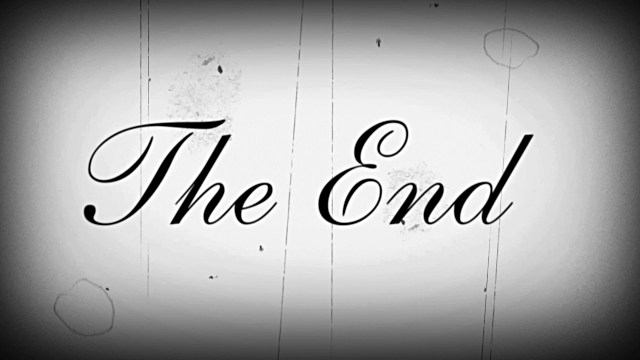